# Simulation of Schwinger model

In this notebook, we investigate realizing (1 + 1)-dimensional quantum electrodynamics (the Schwinger model) on a few-qubit trapped-ion quantum computer. We implement and deploy the algorithm developed in [[1605.04570]](https://arxiv.org/abs/1605.04570). 

## 1. Introduction


## 2. Hamiltonian to be simulated

After some simplification, the Hamiltonian of the Schwinger model can be written as
$$
H=J \sum_{i=1}^{N-1}(\frac{1}{2} \sum_{j=1}^i\left[Z_j+(-1)^j\right])^2+\frac{w}{2}\sum_{i=1}^{N-1} (X_iX_{i+1}+Y_iY_{i+1})+\frac{m}{2} \sum_{i=1}^N(-1)^n Z_i
$$

where the first part represents Long-range interaction, the second part represents particle–antiparticle creation, the last part represents Particle mass.

The challenge of simulating this model is that the Hamiltonian is not a sum of local terms, it requires long range interactions. Fortunately, the trapped-ion quantum computer can be programmed to implement the long range interactions.

First, we program the Hamiltonian as discusses.

In [1]:
# Generate a Schwinger model in pure spin Hamiltonian

import numpy as np
from simuq.qsystem import QSystem
from simuq.environment import qubit

def Schwinger(n, T=1, m=0.5, w=1, J=1, eps_0=0):
    qs = QSystem()
    q = [qubit(qs) for i in range(n)]
    H = 0
    for i in range(n - 1): # the first part
        S = 0
        for j in range(i):
            S += (q[j].Z + (-1)**j)/2
        H += J * (eps_0 + S) * (eps_0 + S)
    for i in range(n):
        H += m / 2 * (-1)**i * q[i].Z
    for i in range(n - 1):
        H += w / 2 * (q[i].X * q[i+1].X + q[i].Y * q[i+1].Y)

    qs.add_evolution(H, T)
    return qs

Next, we create IonQ backend and run the simulation.

In [6]:
from simuq.providers import IonQProvider

ionqp = IonQProvider(from_file="../../../ionq_API_key")

The initial state is all vaccum, which is $|1010\rangle$ in the encoding of the Schwinger model.

In [7]:
def Xgate(q):
    gate = {"gate": "gpi", "target": q, "phase": 0.}
    return gate
state_prep = {"circuit": [Xgate(0), Xgate(2)]}

The result is evaluated by counting the number of particles and antiparticles.

In [14]:
import matplotlib.pyplot as plt

def draw_results(steps, results_list):
    density_list = []
    for result in results_list:
        density = 0
        for state in result:
            density += result[state] * sum(1 for a, b in zip(state, "0101") if a != b) / 4
        density_list.append(density)
    plt.plot(steps, density_list, "o-")

Finally, we can run the simulation and plot the results.

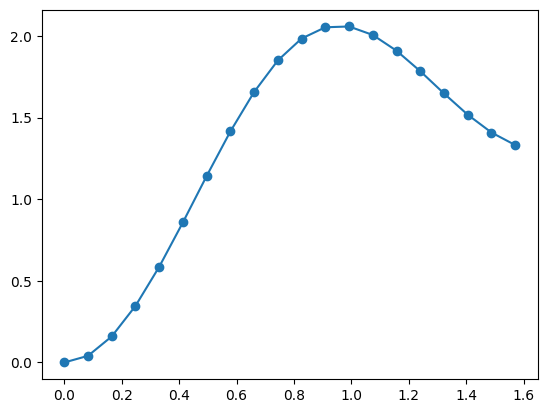

In [18]:
import time
timestep=np.linspace(0, np.pi/2, 20)
results_list = []
for t in timestep:
    walk = Schwinger(4, t)
    ionqp.compile(walk, backend="aria-1", trotter_num=14, state_prep=state_prep)
    ionqp.run(shots=4096, on_simulator=True, verbose=-1)
    while True:
        time.sleep(1)
        res = ionqp.results(verbose=-1)
        if res is not None:
            break
    results_list.append(res)

draw_results(timestep, results_list)